# CE888 Assignment 2 for Demo

This code is written to demonstarte data analysis made for ce888 assignment 2.

**Author**          : Tomoko Ayakawa<br> 
**Created on**      : 29 March 2019<br> 
**Last modified on**: 6 April 2019<br> 

In [1]:
# import open source libraries
import pandas as pd 
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import sys

# import original libraries
sys.path.append("../")

import utility as UTL
#import assignment1_main as MAIN
import load_data as DATA
import histogram as HST
from conf import myVariables as VAR
import correlation as CRRL
import pca as PCA
import classifier as CLS
import feature_importance as IMP

## 1. Load Data
Load data from **data** directory.<br>
Reading and preprocessing data into pandas.DataFrame are done by respective python files.<br>
#### Returned variables<br>
>`col_names` : List --- Name of the columns (including target column)<br>
`features_df` : DataFrame --- Feature values<br>
`targets_df` : DataFrame --- Target values<br>
`data_df` : DataFrame --- The whole data containing both features and targets<br>
`pic_file`: String --- Prefix for file name (data name + timestamp)<br>
`unique_labels` : List --- Column haeders containing feature names and terget name ("Class")
>

#### Select data to load (Argument `data_id`)
> 0. Human Activity
1. Spam
2. Phishing
>

In [2]:
data_list={0: "human activity", 1: "spam", 2: "phishing"}
data_id = int(input(data_list))

col_names, features_df, targets_df, data_df, pic_file = DATA.load_data(data_id=data_id)
unique_labels = DATA.verify_data(data_df, targets_df, dispaly_range=False)

{0: 'human activity', 1: 'spam', 2: 'phishing'}2
Number of NaN: 0
Data shape:  (11055, 31)
Target labels: [-1.  1.]
Class distribution: ['0.44', '0.56']


In [ ]:
#display the first 5 rows of the selected data
data_df.head(5)

## 2. Pre-process the data
### 2-1. Obtain the small data
`get_small_data` returns the specified number of samples. <br>
If `min_samples` is **None**, then **50 + 8\*num_cols** samples will be returned.

In [3]:
min_samples=input("Enter the number of samples to use (Total: %d): " % data_df.shape[0])
try:
    min_samples=int(min_samples)
except:
    min_samples=None
    
features, classes=UTL.get_small_data(features_df.values, targets_df.values, min_samples=min_samples)

Enter the number of samples to use (Total: 11055): 
ratio: 0.026232473993668022
Minimul size of the data for 30 features: 290
The size of the data used for classification: 290


### 2-2. Fit the scaler and transform the data

In [4]:
def pre_processing(X, mode):   
    from sklearn.preprocessing import \
        MinMaxScaler, QuantileTransformer, StandardScaler
    
    # fit the scalar
    if mode==0:
        scl=None
        X_nrm=X
    else:
        if mode==1: scl=MinMaxScaler()
        if mode==2: scl=QuantileTransformer(output_distribution="normal")
        if mode==3: scl=StandardScaler()
        scl.fit(X)
        X_nrm=scl.transform(X)
    
    print("Scaler:", scl)
    
    return scl, X_nrm

In [5]:
scaler=int(input("Select the scaler 0 (None), 1 (MinMax), 2 (Quantile), 3 (Standard): "))

scl_features, features_nrm=pre_processing(features, scaler)
features_nrm[:5]

Select the scaler 0 (None), 1 (MinMax), 2 (Quantile), 3 (Standard): 0
Scaler: None


array([[ 1., -1.,  1.,  1.,  1., -1., -1.,  0., -1.,  1.,  1.,  1., -1.,
         0., -1., -1.,  1.,  1.,  0.,  1.,  1.,  1.,  1., -1.,  1.,  0.,
        -1.,  1.,  0.,  1.],
       [ 1.,  1.,  1.,  1.,  1., -1., -1.,  1., -1.,  1.,  1.,  1.,  1.,
         0., -1., -1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        -1.,  1.,  0.,  1.],
       [ 1., -1.,  1.,  1.,  1., -1., -1.,  1.,  1.,  1.,  1.,  1., -1.,
         0.,  0., -1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  0.,  1.],
       [ 1., -1.,  1.,  1.,  1., -1.,  0., -1.,  1.,  1.,  1., -1., -1.,
        -1., -1., -1., -1., -1.,  0.,  1.,  1.,  1.,  1.,  1., -1.,  0.,
        -1.,  1., -1., -1.],
       [ 1., -1.,  1.,  1.,  1., -1.,  0.,  1., -1.,  1.,  1.,  1., -1.,
         0.,  0.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  1., -1.,  1.,  1.,
         1.,  1.,  0.,  1.]])

## 3. Split the training dataset

In [6]:
def split_data(X, y, test_size=0.2):
    from sklearn.model_selection import train_test_split
    
    X_tr, X_te, Y_tr, Y_te=train_test_split(X, y, test_size=test_size)
    print("Training: %d, Test: %d" % (len(X_tr), len(X_te)))
    
    return X_tr, X_te, Y_tr, Y_te

In [7]:
test_size=float(input("Enter the test_size (0<=test_size<1): "))
X_tr, X_te, Y_tr, Y_te=split_data(features_nrm, classes, test_size=test_size)

Enter the test_size (0<=test_size<1): 0
Training: 290, Test: 0


## 4. Build an Autoencoder
### 4-1. Define the parameters
- `num_outs`: number of outputs
- `act_funcs`:activation functions
- `opt`:optimiser
- `loss`: loss function
- `tr_epoch`: training epoch
- `ver`: verbose

In [198]:
num_outs=[20, 10, 5]
act_funcs=["relu"] * len(num_outs) 
opt="adam"
loss="mse"
tr_epoch=10
ver=0

### 4-2. Build an autoencoder
#### (1) Autoencoder

In [199]:
def autoencoder(X, epochs=20, verbose=1): 
    from keras.models import Sequential, Model
    from keras.layers import Dense, Input
    from keras.optimizers import Adam
    from keras.layers.advanced_activations import PReLU
    import warnings
    
    #ignore warnings
    warnings.filterwarnings("ignore")
    
    #create an input holder
    num_features=len(X[0])
    input_holder=Input(shape=(num_features,))
        
    #initialise the encoder variables
    num_outs.insert (0, num_features)
    act_funcs.insert (0, "Inputs")
    tmp_holder = input_holder

    #initialise the decoder variables
    n=len(num_outs)
    num_out_dec=[]
    for i in range(n-1, -1, -1): num_out_dec.append(num_outs[i])     
    num_out_dec.append(num_features)
    act_funcs_dec=[act_funcs[-1]]*len(num_out_dec)
    
    print("num_outs:", num_outs, num_out_dec)
    print("act:", act_funcs, act_funcs_dec)
    #build an encoder
    encode = input_holder
    for i in range (0, n-1):
        print("i=",i,"| output=", num_outs[i+1], ", input=",num_outs[i],", act=",act_funcs[i+1])
        
        encode=Dense(num_outs[i+1], input_dim=num_outs[i], \
                    activation = act_funcs[i+1])(encode)
    decode = encode
    for i in range (0, len(act_funcs)-1):
        print("i=",i,"| output=", num_out_dec[i+1], ", input=",num_out_dec[i],", act=",act_funcs_dec[i+1])
        decode = Dense ( num_out_dec[i+1], input_dim=num_out_dec[i], \
                        activation=act_funcs_dec[i+1])(decode)
    
    autoencoder=Model(input=input_holder, output=decode)
    autoencoder.compile (optimizer = "adam", loss = "mse")
    
    #train the autoencoder
    loss_hiss=autoencoder.fit (X, X, epochs=epochs, verbose=verbose)
    
    return encode, [loss_hiss]

In [200]:
encoder, loss_hiss=autoencoder(X_tr, epochs=tr_epoch, verbose=ver)

num_outs: [30, 20, 10, 5] [5, 10, 20, 30, 30]
act: ['Inputs', 'relu', 'relu', 'relu'] ['relu', 'relu', 'relu', 'relu', 'relu']
i= 0 | output= 20 , input= 30 , act= relu
i= 1 | output= 10 , input= 20 , act= relu
i= 2 | output= 5 , input= 10 , act= relu
i= 0 | output= 10 , input= 5 , act= relu
i= 1 | output= 20 , input= 10 , act= relu
i= 2 | output= 30 , input= 20 , act= relu


AttributeError: 'Tensor' object has no attribute 'summary'

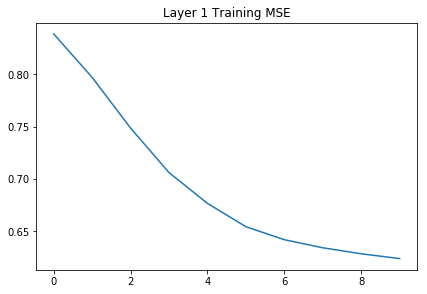

In [197]:
plot_ae_loss_history(loss_hiss, pic_file="test")

#### (2) Stacked Autoencoder

In [186]:
def stacked_autoencoder(X, epochs=20, verbose=1): 
    from keras.models import Sequential, Model
    from keras.layers import Dense, Input
    from keras.optimizers import Adam
    from keras.layers.advanced_activations import PReLU
    import warnings
    
    # ignore warnings
    warnings.filterwarnings("ignore")

    #create an input holder
    num_features=len(X[0])
    input_holder=Input(shape=(num_features,))
        
    #initialise the variables
    num_outs.insert(0, num_features)
    tmp_holder = input_holder
    tr_data=X
    encoders = []
    loss_hiss = []

    #train encoder layers
    for i in range(len(act_funcs)):
        print("Training Layer %d/%d ..." % (i+1, len(act_funcs)))
        encode=Dense(num_outs[i+1], input_dim=num_outs[i], \
                       activation=act_funcs [i])(tmp_holder)
        decode=Dense(num_outs[i], input_dim=num_outs[i+1], \
                       activation=act_funcs[i])(encode)
        encoder=Model(input=tmp_holder, output=decode)
        encoder.compile(optimizer=opt, loss=loss)
    
        # train a layer
        loss_his=encoder.fit(tr_data, tr_data, epochs=epochs, verbose=verbose)
        loss_hiss.append(loss_his)
        
        # use output of the layer as next training input
        encoder = Model(input=tmp_holder, output=encode)
        tr_data=encoder.predict(tr_data)
        
        # update the input_holder
        tmp_holder=Input(shape=(num_outs[i+1],))
    
        # store the trainined layer in a list
        encoders.append(encoder)
        
    # connect traind encoder layers as 'encode'
    encoder=Sequential()
    for e in encoders:
        encoder.add (e)
        
    return encoder, loss_hiss

### 4-3. Train the autoencoder

In [187]:
encoder, loss_hiss=stacked_autoencoder(X_tr, epochs=tr_epoch, verbose=ver)
encoder.summary()

Training Layer 1/3 ...
Training Layer 2/3 ...
Training Layer 3/3 ...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_13 (Model)             (None, 20)                620       
_________________________________________________________________
model_15 (Model)             (None, 10)                210       
_________________________________________________________________
model_17 (Model)             (None, 5)                 55        
Total params: 885
Trainable params: 885
Non-trainable params: 0
_________________________________________________________________


### 4-4. Display the training history

In [196]:
def plot_ae_loss_history(histories, pic_file):
    fig=plt.figure(figsize=(15,10))
    
    for i in range(len(histories)):
        plt.subplot(2, 2, i+1)
        plt.plot(histories[i].history["loss"])
        plt.title("Layer %d Training %s" % (i+1, loss.upper()))
    
    
    plt.show ()
    
    fig.savefig("%s%s_ae_loss.png" % (VAR.out_path, pic_file), \
                bbox_inches='tight')

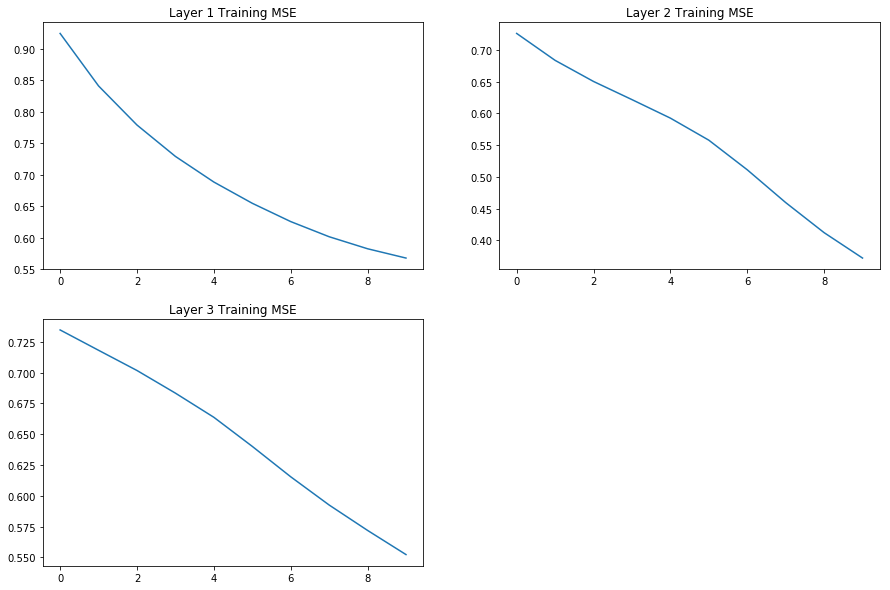

In [189]:
plot_ae_loss_history(loss_hiss, pic_file="test")

### 4-4. Extract features from the datasets

In [12]:
feat_compressed=encoder.predict(features_nrm)
X_tr_compressed=encoder.predict(X_tr)
X_tr_compressed=encoder.predict(X_te)

## 5. Train discriminative neural network
### 5-1. Keras Multiclass classifier
This model is developed in reference to [Multi-Class Classification Tutorial with the Keras Deep Learning Library ](https://machinelearningmastery.com/multi-class-classification-tutorial-keras-deep-learning-library/).

In [37]:
hidden_act='relu'
out_act='softmax'
cls_optimizer="adam"
cls_loss='categorical_crossentropy'

In [38]:
def classifier(num_out=1,finetune=True):
    from keras.models import Sequential
    from keras.layers import Dense, Input

    model=Sequential()
    for e in encoder.layers:
        e.trainable=finetune
        model.add(e)
    model.add(Dense(30, input_dim=num_outs[-1], activation=hidden_act))
    model.add(Dense(num_out, activation=out_act))

    model.compile(loss=cls_loss, optimizer=cls_optimizer, metrics=['accuracy'])    
    
    return model

In [39]:
mlp=classifier(num_out=len(unique_labels), finetune=True)
mlp.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_2 (Model)              (None, 55)                1705      
_________________________________________________________________
model_4 (Model)              (None, 35)                1960      
_________________________________________________________________
model_6 (Model)              (None, 15)                540       
_________________________________________________________________
dense_13 (Dense)             (None, 30)                480       
_________________________________________________________________
dense_14 (Dense)             (None, 2)                 62        
Total params: 4,747
Trainable params: 4,747
Non-trainable params: 0
_________________________________________________________________


In [29]:
def multi_class(Y):
    # For multi class task, replace the target with dummy values
    from keras.utils import np_utils
    from sklearn.preprocessing import LabelEncoder

    # encode class values as integers
    label_encoder=LabelEncoder()
    encoded_Y=label_encoder.fit_transform(Y)

    # convert integers to dummy variables (i.e. one hot encoded)
    encoded_Y=np_utils.to_categorical(encoded_Y)

    return encoded_Y

Y_tr=multi_class(Y_tr)

In [30]:
# Train the network
loss_hiss=mlp.fit(X_tr, Y_tr, epochs=20, validation_split=0.2, verbose=1)

Train on 232 samples, validate on 58 samples
Epoch 1/20
232/232 [==============================] - 0s - loss: 0.7011 - acc: 0.5043 - val_loss: 0.6760 - val_acc: 0.6207
Epoch 2/20
232/232 [==============================] - 0s - loss: 0.6552 - acc: 0.6552 - val_loss: 0.6443 - val_acc: 0.7069
Epoch 3/20
232/232 [==============================] - 0s - loss: 0.6185 - acc: 0.8319 - val_loss: 0.6045 - val_acc: 0.8103
Epoch 4/20
232/232 [==============================] - 0s - loss: 0.5708 - acc: 0.8664 - val_loss: 0.5361 - val_acc: 0.8966
Epoch 5/20
232/232 [==============================] - 0s - loss: 0.4977 - acc: 0.8922 - val_loss: 0.4454 - val_acc: 0.9138
Epoch 6/20
232/232 [==============================] - 0s - loss: 0.4238 - acc: 0.8879 - val_loss: 0.3686 - val_acc: 0.9138
Epoch 7/20
232/232 [==============================] - 0s - loss: 0.3636 - acc: 0.8966 - val_loss: 0.3326 - val_acc: 0.8966
Epoch 8/20
232/232 [==============================] - 0s - loss: 0.3086 - acc: 0.8966 - val_lo

In [31]:
def plot_mlp_loss_history(histories, pic_file):
    fig=plt.figure(figsize=(8,5))

    plt.plot(histories.history["loss"], label="training")
    plt.plot(histories.history["val_loss"], label="validation")
    plt.title("MLP Training and Validation MSE")
    plt.legend()

    plt.show ()
    
    fig.savefig("%s%s_ae_loss.png" % (VAR.out_path, pic_file), \
                bbox_inches='tight')

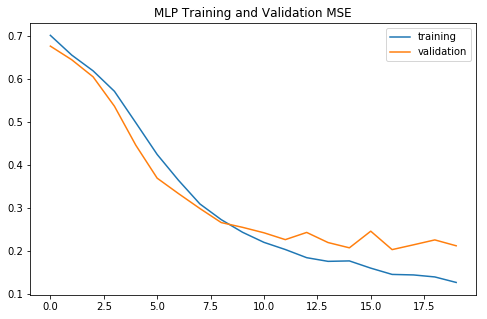

In [32]:
pic_file="test_mlp"
plot_mlp_loss_history(loss_hiss, pic_file)

### 5-2. Sklearn Neural Network

In [33]:
from sklearn.neural_network import MLPClassifier

classifier=MLPClassifier(activation = "tanh", alpha = 1, hidden_layer_sizes = (14,), 
                   max_iter = 8000, learning_rate_init = 0.00001, 
                    solver = "lbfgs")

### (1) Grid Search
The codes and markdown below are originally written by the author for the assignment for CE802 which was submitted to the CSEE Department on 16 January 2019.<br><br>
Major parameters to be tuned are:


|parameter               |default    |description                                              |
|------------------------|-----------|---------------------------------------------------------|
|hidden_layer_sizes      |(100,)     |i-th element: numb of neurons in the i-th hidden layer   |
|activation              |"relu"     |activation function                                      |
|solver                  |"adam"     |weight optimasation                                      |
|alpha                   |0.0001     |regularization parameter                                 |
|learning_rate_init      |0.001      |step-size in weights update (solver=’sgd’ or ‘adam’)     |
|max_iter                |200        |max num of iterations                                    |
|momentum                |0.9        |momentum for gradient descent update (range (0, 1), solver=’sgd’|

In [ ]:
from sklearn.model_selection import \
    GridSearchCV, cross_val_score, KFold, ShuffleSplit
from statistics import mode

Hs=[(100,), (14, ), (28, ), (42, ), (56, )]
ACTs=["identity", "logistic", "tanh", "relu"]
SLOs=["lbfgs", "sgd", "adam"]
ALPHAs=np.logspace (-5, 1, 7)
ITRs=np.linspace (6000, 10000, 5, dtype = int)
ETAs=np.logspace (-5, -3, 3)

param_grid = dict (activation = ACTs, solver = SLOs)
# max_iter = ITRs, learning_rate_init = ETAs, alpha = ALPHAs
# , , hidden_layer_sizes = Hs
print (param_grid)

In [ ]:
clf=GridSearchCV(estimator=classifier, param_grid=param_grid, n_jobs=-1,
                    cv=ShuffleSplit())

In [ ]:
score, bests, lbs, means, modes = [], [], [], [], []
n_splits=10
k_fold=KFold (n_splits=n_splits)

grd = 1
for tr, te in k_fold.split (X):
    print ("\rProgress [%s%s]" % 
           (grd * "# ", (n_splits - grd) * ". "), end = "")
    grd += 1
    best = []
    
    clf.fit (X[tr], y[tr])
    score.append (clf.score(X[te], y[te]))

    for key in param_grid.keys ():
        method = getattr(clf.best_estimator_, key)
        best.append (method)
        if len (lbs) != len (param_grid): lbs.append ("Best %s" % key)
    best.append (score[-1])
    bests.append (best)

lbs.append ("Fold Accuracy")

# append mean and mode
for k in range (len (bests[0])):
    avgs = (np.array (bests)[:, k]).tolist()
    try:    modes.append (mode (avgs))
    except: modes.append ("N/A")

    try:    means.append (np.mean ([float (avg) for avg in avgs]))
    except: means.append ("N/A")

index = ["Fold-%d" % fold for fold in (range (1, grd))]
for add1, add2 in zip ([["---"] * (len (param_grid) + 1), means, modes], 
                       ["---", "mean", "modes"]):
    bests.append (add1)
    index.append (add2)

In [ ]:
# display best scores
print ("\n")
d = pd.DataFrame (bests, index=index, columns=lbs)
print (d)

# export the results to a file
from datetime import datetime
now = datetime.now().strftime("%Y%m%d_%H%M%S")
mystr = input (">>> Enter the type of predictor (for file name): ")
d.to_csv ("GridSearch_%s_%s.csv" % (mystr, now), header = lbs, 
          index = index, sep = ",", mode = "a")
print ("[  O K  ] The result of Grid Search is exported to "
       "<GridSearch_%s_%s.csv>." % (mystr, now))

### (2) Train the network

In [35]:
classifier.fit(X_tr, Y_tr) 

MLPClassifier(activation='tanh', alpha=1, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(14,), learning_rate='constant',
       learning_rate_init=1e-05, max_iter=8000, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='lbfgs', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

### (3) Prediction and Evaluation

In [36]:
pred=classifier.predict(X_te)

# for multi class tasks, decode the class attribute
pred_df=pd.DataFrame(pred, columns=unique_labels)
pred=pred_df.idxmax(axis=1)

ValueError: Found array with 0 sample(s) (shape=(0, 30)) while a minimum of 1 is required.

## 6. Evaluation
### 6-1. Cross Validation

In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score

estimator=KerasClassifier(build_fn=classifier, num_out=num_out, finetune=False, epochs=100, verbose=0)
scores=cross_val_score(estimator, X, y, cv=5)#, n_jobs=-1)

In [ ]:
print("Accuracy (95%% confidence interval): %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

### 6-2. Various evaluation metrics on test data

In [ ]:
from sklearn import metrics
import pandas as pd

print ("\n< Classification Report >")
print (metrics.classification_report (cls_te, pred, digits = 5))

print ("\n< Confusion Matrix >")
print (pd.DataFrame (metrics.confusion_matrix(cls_te, pred)))
print ("Accuracy: %f" % metrics.accuracy_score (cls_te, pred))

print ("\n< Kappa Statistic >")
print (metrics.cohen_kappa_score (cls_te, pred))

CLS.plot_confusion_matrix(cls_te, pred, unique_labels, "test", "NN", "NN")

### 2-4. Classification with other procedures

#### (1) Decision Tree

In [ ]:
title = "%s_Decision_Tree (%d)" % (pic_file, len(X))
true_label, pred_label, clf = CLS.train (feat_te_compressed, cls_te, 0, 0)
#CLS.plot_confusion_matrix(true_label, pred_label, unique_labels, pic_file, title, "Decision_Tree")
clf

#### (2) Naive Bayes

In [ ]:
title = "%s_Naive Bayes (%d)" % (pic_file, len(X))
true_label, pred_label, clf = CLS.train (feat_te_compressed, cls_te, 1, 0)
#CLS.plot_confusion_matrix(true_label, pred_label, unique_labels, pic_file, title, "Naive Bayes")
clf

#### (3) SVM

In [ ]:
title = "%s_SVM (%d)" % (pic_file, len(X))
true_label, pred_label, clf = CLS.train (feat_te_compressed, cls_te, 2, data_id)
#CLS.plot_confusion_matrix(true_label, pred_label, unique_labels, pic_file, title, "SVM")
clf